In [8]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import torch_geometric as pyg
import networkx as nx
import numpy as np
import pandas as pd

from mil.data.mnist import Bag, MNISTBags, OneHotMNISTBags, MNISTCollage, OneHotMNISTCollage
from mil.utils import device, detach, human_format
from mil.models import MILModel
from mil.utils.visualize import print_one_hot_bag_with_attention, print_one_hot_bag, plot_attention_head, plot_bag, plot_one_hot_collage
from mil.utils.stats import print_prediction_stats
from mil.models.attention import WeightedAverageAttention, MultiHeadAttention
from mil.models.set_transformer import SetTransformer, InducedSetTransformer, SAB, ISAB

# MNIST bags / MNIST collage

This notebook trains models on variations of the *mnist-bags*, *multi-mnist-bags*, and *mnist-collage* datasets. 
The goal of this notebook is to see which models are able to overfit on these datasets.


The following cell defines three variables, `DATASET`, `TARGET_NUMBERS` and `MODEL` which can be used to run different dataset/model configurations.

`DATASET`:
- `OneHotMNISTBags`: one-hot version of *mnist-bags*, where the dataset yields 10-dimensional one-hot encoded feature vectors directly (i.e. we are not yet working with MNIST digits)
- `MNISTBags`: the *mnist-bags* dataset
- `OneHotMNISTCollage`: one-hot version of *mnist-collage*
- `MNISTCollage`: *mnist-collage* dataset

`TARGET_NUMBERS`:
- `0` corresponds to the *mnist-bags* dataset
- `(0, 1)` corresponds to the *multi-mnist-bags* dataset

`MODELS`:
- `"mean_pool"`: simple baseline that uses mean pooling. Works neither dataset.
- `"max_pool"`: simple baseline that uses max pooling. Works for *mnist-bags*, but not *multi-mnist-bags*.
- `"weighted_average_attention"`: uses attention mechanism from "Attention Based Deep Multiple Instance Learning" paper which can only "focus" on one target number at a time. Works for *mnist-bags*, but not *multi-mnist-bags*.
- `"self_attention_mean_pooling"`: uses a single transformer layer (self attention) followed by mean pooling. Works for both datasets.
- `"self_attention_max_pooling"`: uses a single transformer layer (self attention) followed by max pooling. Works for both datasets (but better than mean pooling).


Try changing `DATASET`, `TARGET_NUMBERS` and `MODELS` below and rerunning the notebook.

In [27]:
DATASET = OneHotMNISTBags
DATASET = MNISTBags
# DATASET = OneHotMNISTCollage
# DATASET = MNISTCollage

TARGET_NUMBERS = 0
TARGET_NUMBERS = (0, 1)

# MODEL = "mean_pool"
# MODEL = "max_pool"
# MODEL = "weighted_average_attention"
# MODEL = "self_attention_mean_pool"
# MODEL = "self_attention_max_pool"
# MODEL = "set_transformer"
# MODEL = "induced_set_transformer"
# MODEL = "sab_max_pool"
MODEL = "isab_max_pool"
# MODEL = "gcn_max_pool"
# MODEL = "dense_gcn_max_pool"
# MODEL = "gat_max_pool"

# Only for collages
COLLAGE_SIZE = 256
MIN_DIST = 20

NUM_DIGITS = 10
if DATASET.__name__.startswith("OneHot"):
    FEATURE_SIZE = NUM_DIGITS # must be NUM_DIGITS due to one-hot encoding
    HIDDEN_DIM = 10
else:
    FEATURE_SIZE = 64
    HIDDEN_DIM = 10

In [28]:
def make_data_loader(train: bool = True):
    """Utility function to create a data loader for the dataset."""
    extra_kwargs = {}
    if "Collage" in DATASET.__name__:
        extra_kwargs["collage_size"] = COLLAGE_SIZE
        extra_kwargs["min_dist"] = MIN_DIST
    ds = DATASET(target_numbers=TARGET_NUMBERS, # target number
                 num_digits=NUM_DIGITS, # sample from all 10 MNIST digits
                 mean_bag_size=10, # mean bag length
                 var_bag_size=2, # variance of bag length
                 num_bags=250 if train else 100, # number of bags
                 seed=1,
                 train=train,
                 **extra_kwargs)
    loader = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=train, collate_fn=lambda x: x[0])
    return loader

## Define the model

The three parts of the MIL model are:
1. **feature extractor**: extract a feature vector $z \in \mathbb{R}^D$ from each instance. In the case of the one-hot dataset, this is just the identity function. For the actual *mnist-bags* dataset, this is a CNN.
2. **pooling**: a function $f : \mathbb{R}^{N \times D} \to \mathbb{R}^D$ that aggregates the $N$ feature vectors in the bag to a single feature vector.
3. **classifier**: a function $g : \mathbb{R}^D \to \mathbb{R}$ that transforms the aggregated feature vector into a binary classification prediction (we parameterise $g$ using a linear layer followed by a sigmoid)


In [29]:
class OneHotFeatureExtractor(nn.Module):
    def forward(self, bag: Bag):
        # In the case of OneHotBags, the instances are already the features.
        return bag.instances

class CNNFeatureExtractor(nn.Module):
    def __init__(self, feature_size: int):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout2d(.1),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Flatten(-3, -1),
            nn.Dropout(.1),
            nn.Linear(20 * 4 * 4, feature_size),
            nn.ReLU()
        )

    def forward(self, bag: Bag):
        return self.cnn(bag.instances)
        
class GNN(nn.Module):
    """GNN model.
    
    The layer parameter can be used to specify the type of GNN layer to use (e.g. pyg.nn.GCNConv, pyg.nn.GATConv, pyg.nn.DenseGCNConv).
    """

    def __init__(self, feature_size: int, hidden_dim: int, layer=pyg.nn.GCNConv):
        super().__init__()
        self.layer = layer
        self.gnn = pyg.nn.Sequential('x, connectivity', [
            (layer(feature_size, hidden_dim), 'x, connectivity -> x'),
            nn.ReLU(inplace=True),
            (layer(hidden_dim, feature_size), 'x, connectivity -> x'),
            nn.ReLU(inplace=True),
        ])

    def forward(self, bag, features):
        number_of_nodes = features.shape[0]
        instance_locations = bag.instance_locations # TODO: use instance locations if not None
        # Assume complete graph
        if self.layer == pyg.nn.DenseGCNConv:
            # DenseGCNConv requires a dense adjacency matrix
            adj = torch.ones((number_of_nodes, number_of_nodes))
            connectivity = adj
        else:
            edge_index = np.array(nx.complete_graph(number_of_nodes).edges).T # complete (directed) graph
            edge_index = np.concatenate([edge_index, edge_index[::-1]], axis=-1) # undirected graph
            edge_index = torch.from_numpy(edge_index)
            connectivity = edge_index
        batch = torch.tensor([0] * number_of_nodes)
        x = self.gnn(features, connectivity)
        x = pyg.nn.global_max_pool(x, batch)
        return x

class Aggregate(nn.Module):
    """Simple pooling layer for mean/max pooling."""
    def __init__(self, pool: str = "mean", dim: int = 0):
        super().__init__()
        self.pool = pool
        self.dim = dim

    def forward(self, features):
        pool = getattr(torch, self.pool)
        result = pool(features, dim=self.dim)
        if self.pool == "max":
            result = result.values
        return result

class Pooler(nn.Module):
    """Convienience wrapper for pooling layers."""
    def __init__(self, pooling_layer: nn.Module):
        super().__init__()
        self.pooling_layer = pooling_layer
    
    def forward(self, bag, features):
        return self.pooling_layer(features)

class Classifier(nn.Sequential):
    def __init__(self, feature_size: int):
        super().__init__(
            nn.Linear(feature_size, 1),
            nn.Sigmoid()
        )
    
class SqueezeUnsqueeze(nn.Module):
    def __init__(self, module: nn.Module):
        super().__init__()
        self.module = module

    def forward(self, x):
        return self.module(x.unsqueeze(0)).squeeze(0)

# Keep track of attention layer for visualization
attention_layer = None

# Define model
feature_extractor = OneHotFeatureExtractor() if DATASET.__name__.startswith("OneHot") else CNNFeatureExtractor(feature_size=FEATURE_SIZE)
if MODEL == "mean_pool":
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=Pooler(Aggregate("mean")),
                     classifier=Classifier(feature_size=FEATURE_SIZE))
elif MODEL == "max_pool":
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=Pooler(Aggregate("max")),
                     classifier=Classifier(feature_size=FEATURE_SIZE))
elif MODEL == "weighted_average_attention":
    attention_layer = WeightedAverageAttention(feature_size=FEATURE_SIZE, hidden_dim=HIDDEN_DIM)
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=Pooler(attention_layer),
                     classifier=Classifier(feature_size=FEATURE_SIZE))
elif MODEL == "self_attention_mean_pool":
    attention_layer = MultiHeadAttention(feature_size=FEATURE_SIZE, hidden_dim=HIDDEN_DIM)
    pool = nn.Sequential(attention_layer, Aggregate("mean"))
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=Pooler(pool),
                     classifier=Classifier(feature_size=FEATURE_SIZE))
elif MODEL == "self_attention_max_pool":
    attention_layer = MultiHeadAttention(feature_size=FEATURE_SIZE, hidden_dim=HIDDEN_DIM)
    pool = nn.Sequential(attention_layer, Aggregate("max"))
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=Pooler(pool),
                     classifier=Classifier(feature_size=FEATURE_SIZE))
elif MODEL == "set_transformer":
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=Pooler(SetTransformer(dim_input=FEATURE_SIZE, num_outputs=1, dim_output=1, dim_hidden=HIDDEN_DIM, num_heads=1)),
                     classifier=nn.Sigmoid())
elif MODEL == "induced_set_transformer":
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=Pooler(InducedSetTransformer(dim_input=FEATURE_SIZE, num_outputs=1, dim_output=1, dim_hidden=HIDDEN_DIM, num_heads=1, num_inds=32)),
                     classifier=nn.Sigmoid())
elif MODEL == "sab_max_pool":
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=Pooler(nn.Sequential(SqueezeUnsqueeze(SAB(dim_in=FEATURE_SIZE, dim_out=FEATURE_SIZE, num_heads=1)), Aggregate("max"))),
                     classifier=Classifier(feature_size=FEATURE_SIZE))
elif MODEL == "isab_max_pool":
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=Pooler(nn.Sequential(SqueezeUnsqueeze(ISAB(dim_in=FEATURE_SIZE, dim_out=FEATURE_SIZE, num_heads=1, num_inds=32)), Aggregate("max"))),
                     classifier=Classifier(feature_size=FEATURE_SIZE))
elif MODEL == "gcn_max_pool":
    gnn = GNN(feature_size=FEATURE_SIZE, hidden_dim=HIDDEN_DIM, layer=pyg.nn.GCNConv)
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=gnn,
                     classifier=Classifier(feature_size=FEATURE_SIZE))
elif MODEL == "dense_gcn_max_pool":
    gnn = GNN(feature_size=FEATURE_SIZE, hidden_dim=HIDDEN_DIM, layer=pyg.nn.DenseGCNConv)
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=gnn,
                     classifier=Classifier(feature_size=FEATURE_SIZE))
elif MODEL == "gat_max_pool":
    gnn = GNN(feature_size=FEATURE_SIZE, hidden_dim=HIDDEN_DIM, layer=pyg.nn.GATConv)
    model = MILModel(feature_extractor=feature_extractor,
                     pooler=gnn,
                     classifier=Classifier(feature_size=FEATURE_SIZE))
else:
    raise ValueError(f"Unknown model {MODEL}")


## Define loss function and optimizer

We use binary cross-entropy loss.

In [30]:
loss_function = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

Helper code to evaluate on test set:

In [31]:
test_loader = make_data_loader(train=False)

def test_loss_and_error(model, loader):
    model.eval()

    total_loss = 0.
    total_error = 0.
    predictions = []

    with torch.no_grad():
        for i, bag in enumerate(loader):
            bag = device(bag)
            y = bag.bag_label.float()

            # Calculate loss and metrics
            y_pred = model(bag).squeeze()
            loss = loss_function(y_pred, y)

            predictions.append((detach(device(bag, "cpu")), y_pred.detach().cpu()))

            error = 1. - ((y_pred > .5).float() == y).cpu().detach().float()
            total_error += error
            total_loss += loss.detach().cpu()
    return total_loss / len(loader), total_error / len(loader), predictions

## Train

In [32]:
loader = make_data_loader(train=True)

stats = []

model.train()
print(f"Training model with {human_format(sum(p.numel() for p in model.parameters() if p.requires_grad))} parameters")

for epoch in range(40):
    model.train()

    total_loss = 0.
    total_error = 0.
    for bag in loader:
        bag = device(bag)
        y = bag.bag_label

        optimizer.zero_grad()

        # Calculate loss and metrics
        y_pred = model(bag).squeeze()
        loss = loss_function(y_pred, y)

        error = 1. - ((y_pred > .5).float() == y).cpu().detach().float()
        total_error += error
        
        # Backward pass
        loss.backward()

        total_loss += loss.detach().cpu()
        # Step
        optimizer.step()
    
    test_loss, test_error, _ = test_loss_and_error(model, test_loader)

    stats.append({
        "epoch": epoch,
        "loss": total_loss / len(loader),
        "error": total_error / len(loader),
        "test_loss": test_loss,
        "test_error": test_error
    })
    print(
        f"Epoch: {epoch:3d}, loss: {total_loss/len(loader):.4f}, error: {total_error/len(loader):.4f}, test_loss: {test_loss:.4f}, test_error: {test_error:.4f}")

# Plot training and test loss/error
stats = pd.DataFrame(stats)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("Loss")
plt.plot(stats["epoch"], stats["loss"], label="train")
plt.plot(stats["epoch"], stats["test_loss"], label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(122)
plt.title("Error")
plt.plot(stats["epoch"], stats["error"], label="train")
plt.plot(stats["epoch"], stats["test_error"], label="test")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()

Training model with 42.5K parameters
Epoch:   0, loss: 0.6970, error: 0.4560, test_loss: 0.6387, test_error: 0.4500
Epoch:   1, loss: 0.4966, error: 0.2160, test_loss: 0.3390, test_error: 0.1200
Epoch:   2, loss: 0.2990, error: 0.1120, test_loss: 0.1703, test_error: 0.0600
Epoch:   3, loss: 0.2146, error: 0.0600, test_loss: 0.2075, test_error: 0.0600
Epoch:   4, loss: 0.1358, error: 0.0440, test_loss: 0.1462, test_error: 0.0300
Epoch:   5, loss: 0.2228, error: 0.0920, test_loss: 0.1239, test_error: 0.0400
Epoch:   6, loss: 0.0957, error: 0.0280, test_loss: 0.2258, test_error: 0.0600
Epoch:   7, loss: 0.1160, error: 0.0320, test_loss: 0.2231, test_error: 0.0700
Epoch:   8, loss: 0.1431, error: 0.0360, test_loss: 0.1398, test_error: 0.0200
Epoch:   9, loss: 0.0531, error: 0.0160, test_loss: 0.6497, test_error: 0.1300
Epoch:  10, loss: 0.1169, error: 0.0360, test_loss: 0.1487, test_error: 0.0500
Epoch:  11, loss: 0.0860, error: 0.0280, test_loss: 0.1273, test_error: 0.0400
Epoch:  12, los

## Test

In [26]:
test_loss, test_error, predictions = test_loss_and_error(model, test_loader)
print(f"Test loss: {test_loss:.4f}, test error: {test_error:.4f}")

print_prediction_stats(predictions, target_numbers=TARGET_NUMBERS)

Test loss: 0.1023, test error: 0.0200

                                 % acc    total    -pred    +pred     example
  bags                              98      100       48       52     0 8 8 5 6 0 3 6 4 9
  bags with 0s                     100       71       21       50     0 8 8 5 6 0 3 6 4 9
  bags without 0s                   93       29       27        2     9 3 1 2 8 9
  bags with 0s and 1s              100       50        0       50     0 3 5 9 0 3 6 5 1 1 8
  bags with 0s and not 1s          100       21       21        0     0 8 8 5 6 0 3 6 4 9
  bags with 1s                      97       72       20       52     0 3 5 9 0 3 6 5 1 1 8
  bags without 1s                  100       28       28        0     0 8 8 5 6 0 3 6 4 9
  bags with 1s and 0s              100       50        0       50     0 3 5 9 0 3 6 5 1 1 8
  bags with 1s and not 0s           90       22       20        2     9 3 1 2 8 9
  bags with 2 key instance(s)      100       19        0       19     0 1 2 8 3 6 9

### First 10 bags in test dataset

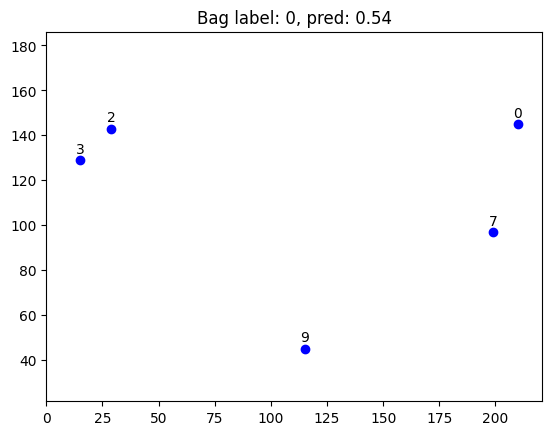

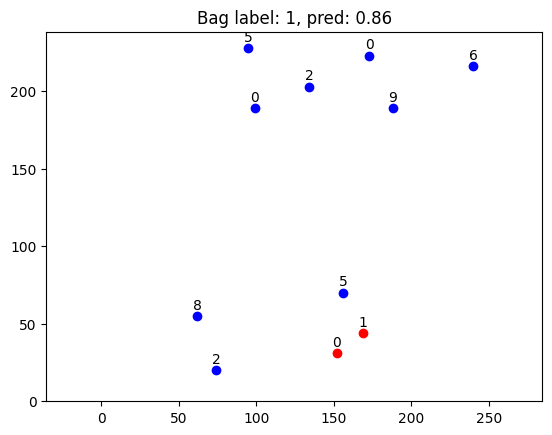

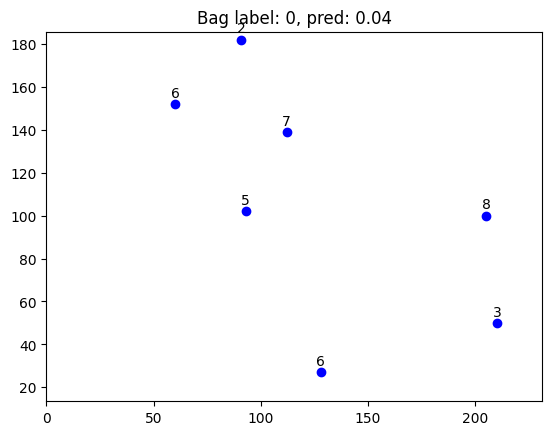

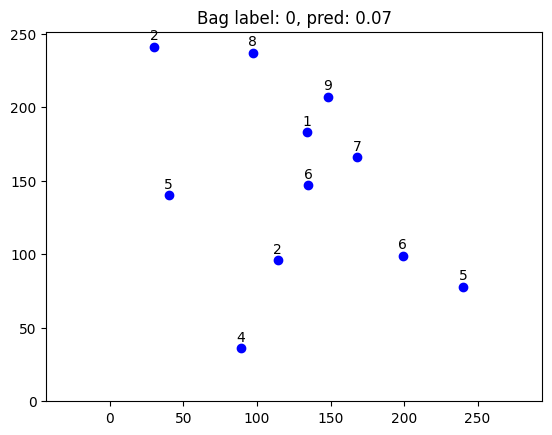

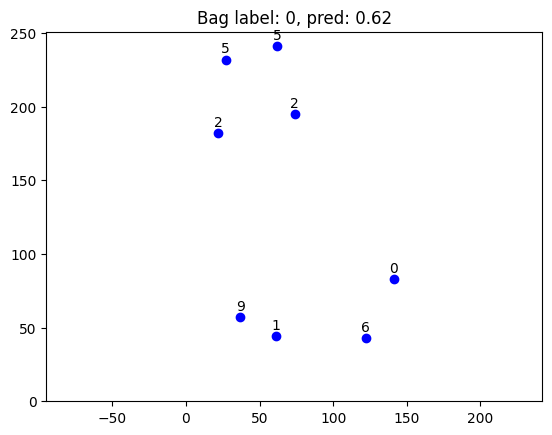

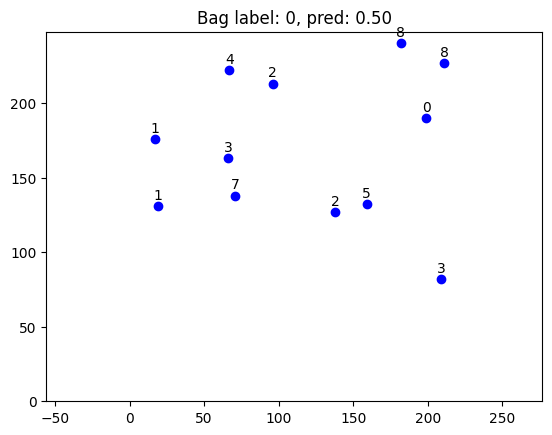

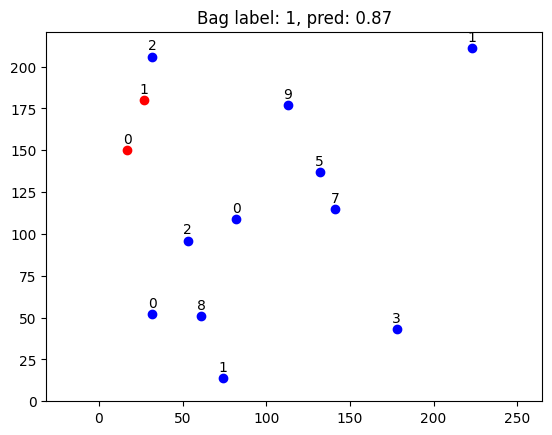

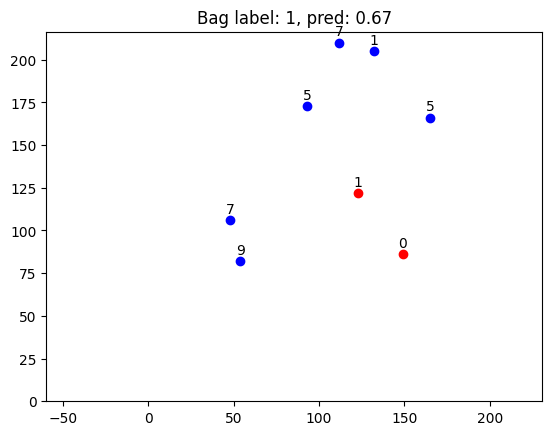

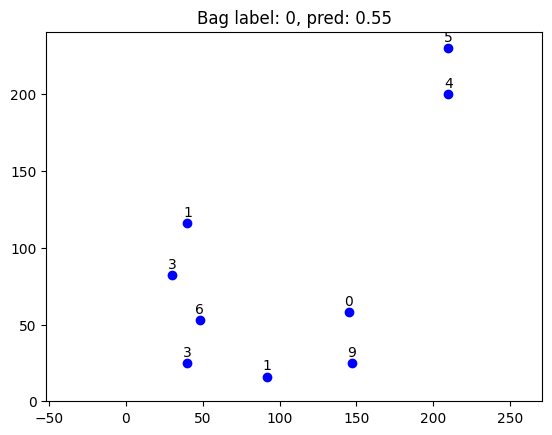

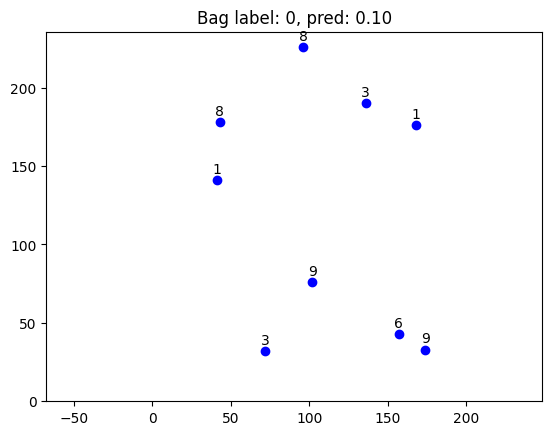

In [9]:
def visualize_prediction(bag, y_pred):
    y = bag.bag_label
    if DATASET == OneHotMNISTBags:
        if isinstance(attention_layer, WeightedAverageAttention):
            print_one_hot_bag_with_attention(bag, attention_layer.A, y_pred>.5)
            print()
        elif isinstance(attention_layer, MultiHeadAttention):
            plt.figure()
            plot_attention_head(bag, attention_layer.A[0])
            plt.title(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
        else:
            print_one_hot_bag(bag, y_pred>.5)
    elif DATASET == MNISTBags:
        if isinstance(attention_layer, WeightedAverageAttention):
            plot_bag(bag, y_pred=y_pred, attention=attention_layer.A.squeeze(-1))
        elif isinstance(attention_layer, MultiHeadAttention):
            plot_bag(bag, y_pred=y_pred)
            plt.figure()
            plot_attention_head(bag, attention_layer.A[0])
            plt.title(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
        else:
            plot_bag(bag, y_pred=y_pred)
    elif DATASET == OneHotMNISTCollage:
        plt.figure()
        plot_one_hot_collage(bag, y_pred=y_pred)
        plt.title(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")

# Visualize first 10 bags
model.eval()
with torch.no_grad():
    for bag in itertools.islice(test_loader, 10):
        bag = device(bag)
        y = bag.bag_label.float()
        y_pred = model(bag).squeeze(0)
        visualize_prediction(bag, y_pred)

### First 10 mistakes in test dataset

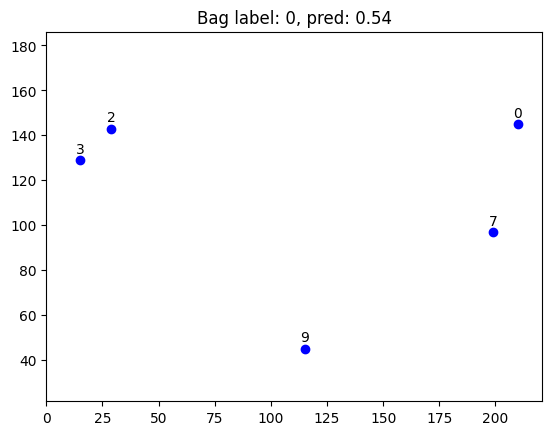

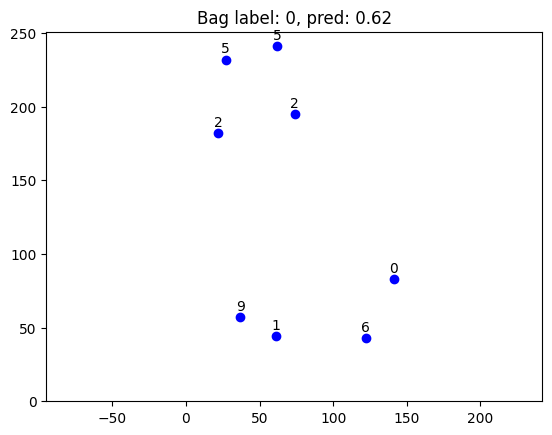

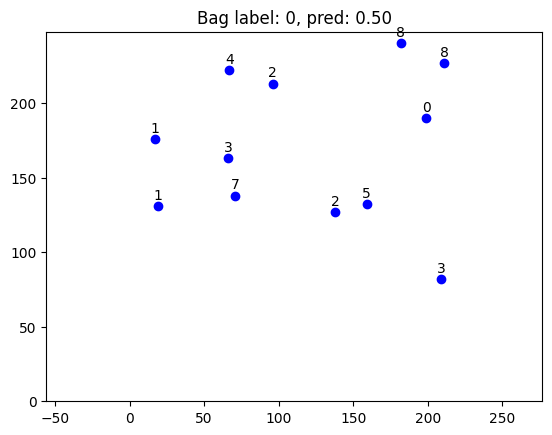

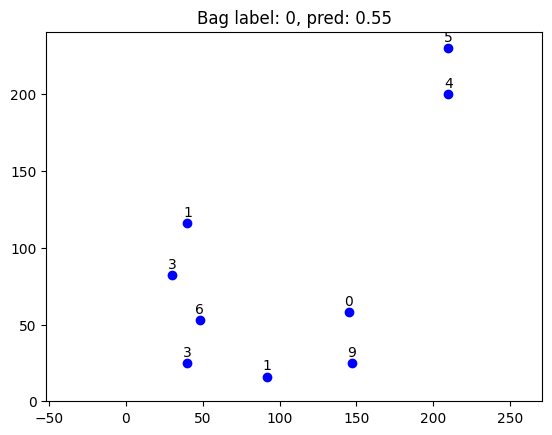

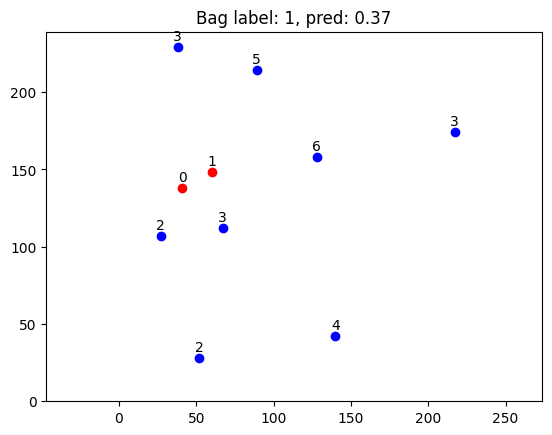

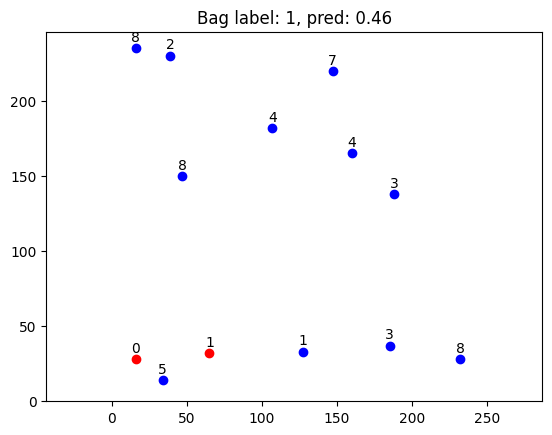

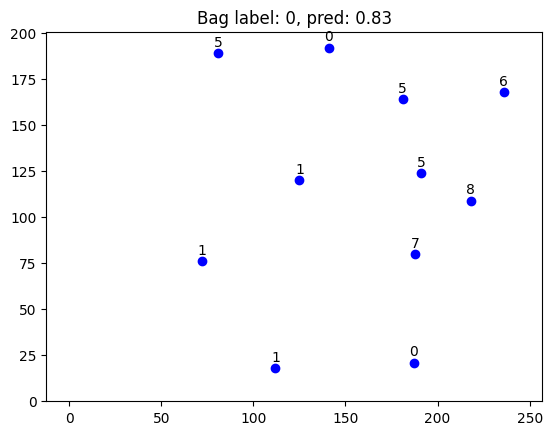

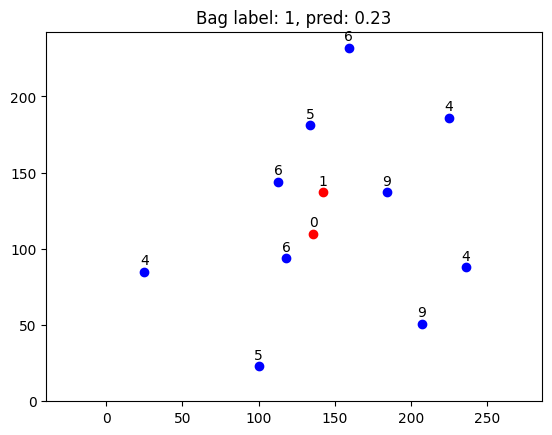

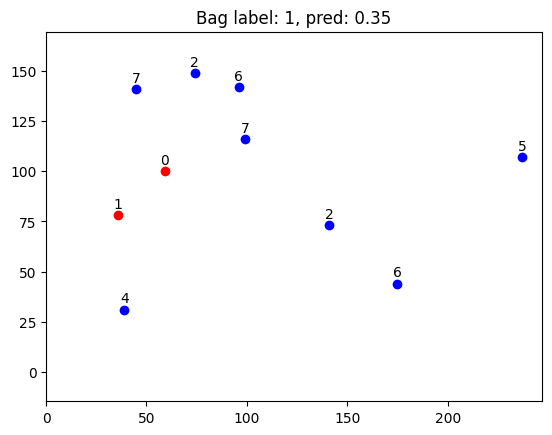

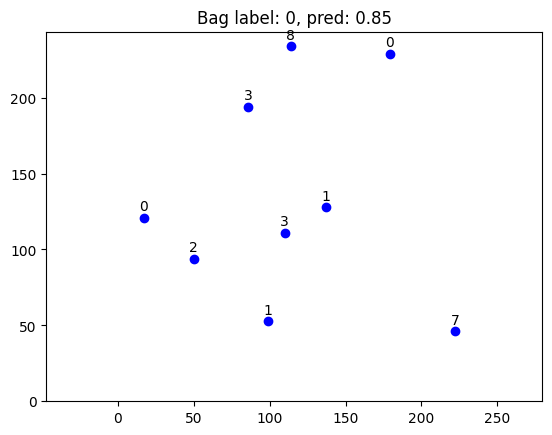

In [10]:
# Visualize first 10 mistakes
model.eval()
with torch.no_grad():
    i = 0
    for bag in test_loader:
        if i == 10:
            break
        bag = device(bag)
        y = bag.bag_label.float()
        y_pred = model(bag).squeeze(0)
        if ((y_pred > .5).float() != y).cpu().detach():
            visualize_prediction(bag, y_pred)
            i += 1